# Single KAN Learning Example (Shape 4-4-3)
This notebook demonstrates how to train a single KAN (Kolmogorov-Arnold Network) model with the architecture [4, 4, 3].

We will:
- Generate a synthetic dataset
- Train a KAN model on this data
- Extract and display the symbolic expression learned by the model
- Explain each step in detail for non-programmers

## 1. Import Required Libraries
We start by importing the necessary Python libraries. These libraries help us with data handling, mathematical operations, neural network modeling, and symbolic math.

In [1]:
import os
import sys
# Add the parent directory to the path so we can import our custom modules
if "../" not in sys.path:
    sys.path.append("../")
from src.kharkan.modelKAN import KharKAN, _clean_expr
from src.kharkan.NMR import get_frequences_ordered
import numpy as np
import torch
import time
import tqdm
import sympy as sp
from sympy import Expr
import matplotlib.pyplot as plt
import time

## 2. Utility Functions for Symbolic Math
These functions help us clean up and simplify the mathematical expressions produced by the KAN model.

In [2]:
def fix_powers(expr: sp.Expr) -> sp.Expr:
    """Convert floating-point exponents that are actually integers to integer exponents."""
    if not isinstance(expr, sp.Expr):
        return expr
    return expr.replace(
        lambda e: isinstance(e, sp.Pow) and isinstance(e.exp, sp.Float) and float(e.exp).is_integer(),
        lambda e: sp.Pow(e.base, int(e.exp))
    )

def round_expr(expr: sp.Expr, digits: int = 5) -> sp.Expr:
    """Round all numbers in the expression to a given number of digits."""
    nums = {n: round(float(n), digits) for n in expr.atoms(sp.Number)}
    return expr.xreplace(nums)

## 3. Generate a Synthetic Dataset
We create a dataset with two input variables (`x0` and `x1`) and a target value that is a simple function of these inputs. This helps us test if the KAN model can learn the underlying relationship.

### 3A. Flexible Dataset Generation Functions

We now provide two dataset generation functions:
- `make_dataset`: Accepts minimum/maximum borders and a ratio threshold for input filtering.
- `make_dataset_from_function`: Accepts a custom function of two variables to generate labels, with the same input filtering as above.

This allows for more flexible and reusable dataset creation for different experiments.

In [3]:
def make_dataset_from_function(num_samples: int, func, min_x: float = -32, max_x: float = -5, min_y: float = -15, max_y: float = -0.1, ratio_threshold: float = 100):
    """
    Generate a dataset using a user-supplied function of two variables.
    Returns a dict with 'train_input' and 'train_label' as torch tensors.
    """
    samples_collected = 0
    xsez_list, ysez_list, ratioX_list, ratioY_list, label_list = [], [], [], [], []
    while samples_collected < num_samples:
        batch_size = int((num_samples - samples_collected) * 1.5) + 10
        x0 = np.random.rand(batch_size) * (max_x - min_x) + min_x
        x1 = np.random.rand(batch_size) * (max_y - min_y) + min_y
        ratioX = x0 / x1
        ratioY = x1 / x0
        mask = (
            (np.abs(ratioX) < ratio_threshold*10)
            & (np.abs(ratioY) < ratio_threshold*10)
            )
        x0, x1, ratioX, ratioY = x0[mask], x1[mask], ratioX[mask], ratioY[mask]
        labels = func(x0, x1)
        labels=np.array(labels, dtype=np.float32).T
        xsez_list.append(x0)
        ysez_list.append(x1)
        ratioX_list.append(ratioX)
        ratioY_list.append(ratioY)
        label_list.append(labels)
        samples_collected += len(x0)
    x0 = np.concatenate(xsez_list)[:num_samples]
    x1 = np.concatenate(ysez_list)[:num_samples]
    ratioX = np.concatenate(ratioX_list)[:num_samples]
    ratioY = np.concatenate(ratioY_list)[:num_samples]
    labels = np.concatenate(label_list)[:num_samples]
    return {
        'train_input': torch.tensor(
            np.stack([x0, x1, ratioX, ratioY], axis=1)
        ).float(),
        'train_label': torch.tensor(labels).float()
    }

# get

In [4]:
def get_perturbation(x,y):
    """
    Example perturbation function.
    Returns a small perturbation based on the input values.
    """
    f0=x/2**0.5+x*x/8/y
    f1=x/2**0.5-x*x/8/y
    f2=x*2**0.5
    return (f0, f1, f2)
# Example usage with a custom function
data = make_dataset_from_function(20000, get_perturbation, min_x=-1, max_x=1, min_y=-1, max_y=1, ratio_threshold=30)
# Example usage with get_frequences_ordered
#data = make_dataset_from_function(20000, get_frequences_ordered, min_x=-1, max_x=1, min_y=-0.1, max_y=0.1, ratio_threshold=10)
# fix wrong shapes assignments
#data['train_label']=torch.tensor(get_frequences_ordered(data['train_input'][:,:2])).float()

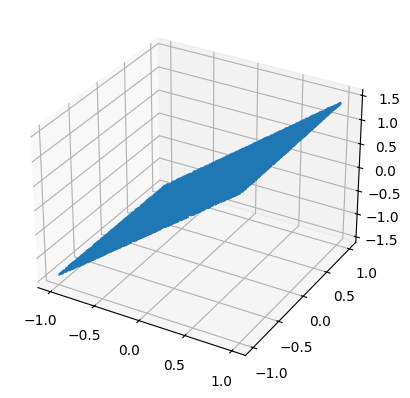

In [5]:
# plot data
ax3d = plt.figure().add_subplot(projection='3d')
ax3d.scatter(data['train_input'][:, 0].numpy(), data['train_input'][:, 1].numpy(), data['train_label'][...,2].numpy(), s=1)

## 4. Set Training Parameters
We define the parameters for training the KAN model, such as the number of training epochs, learning rate, and regularization strength.

In [6]:
EPOCHS = 200000  # Number of times the model will see the entire dataset
LR = 0.0001      # Learning rate (how big each step is during training)
CLIP_NORM = 0.1 # Maximum allowed value for gradients (for stability)
L05_PENALTY = 0.1 # Regularization strength (to encourage simpler models)

## 5. Initialize the Model and Optimizer
We create the KAN model with the desired shape, set up the optimizer (Adam), and define the loss function (mean squared error).

In [7]:
# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model with the desired input and output shape
shape = (4, 4, 3)  # 4 inputs, 3 hidden layers, 3 output
model = KharKAN(shape).to(device)

# Set up optimizer and loss function 
optimizer = torch.optim.Adam(model.parameters(), lr=LR) # http://arxiv.org/pdf/1412.6980
criterion = torch.nn.MSELoss(reduction="none") 

# Move data to the selected device
inputs = data['train_input'].to(device)
labels = data['train_label'].to(device)

Using device: cuda


## 6. Train the Model
We train the KAN model using the dataset. The training loop updates the model to minimize the difference between its predictions and the true values.

- The progress bar shows the current loss and relative error.
- Regularization is used to encourage the model to find simpler (more interpretable) formulas.
- l05 regularization is trying to keep sum of the root of the weights small, which leads to setting some all of the weights in neuron to zero except of one. L05 penalty term is used to encourage the model to find simpler (more interpretable) formulas.

In [8]:
loop_start = time.time()
pbar = tqdm.tqdm(range(EPOCHS), desc="Epochs")
prev_loss = float('inf')  # Initialize previous loss to a large value
last_anneal_epoch = None  # Track the last anneal epoch
for i in pbar:
    optimizer.zero_grad()
    preds = model(inputs)
    mse = criterion(preds, labels)
    mse_norm = mse / (torch.abs(labels) + 1e-8)
    l05_penalty = model.L05_loss()  # L0.5 regularization
    loss = mse.mean() + L05_PENALTY * l05_penalty + mse_norm.mean() * 100  # Combine losses
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CLIP_NORM)
    optimizer.step()
    if i % 100 == 0 or i == EPOCHS - 1:
        pbar.set_postfix(
            {
                "mse": mse.mean().item(),
                "l05": (L05_PENALTY * l05_penalty).item(),
                "loss": loss.item(),
                "rel_err": (
                    torch.mean(
                        torch.abs(preds - labels) / torch.abs(labels + 1e-8)
                    ).item()
                ),
                "last_anneal": last_anneal_epoch,
            }
        )
        # if difference in loss is less than 0.1 percent, anneal the weights
        #if abs(prev_loss - mse.mean().item()) < 1e-4 * mse.mean() and mse.mean().item() > 1e-2:
        #    model.anneal(rate=1e-4)  # Anneal the weights
        #    last_anneal_epoch = i
        prev_loss = mse.mean().item()

Epochs: 100%|██████████| 200000/200000 [05:15<00:00, 633.40it/s, mse=0.00188, l05=1.12, loss=1.25, rel_err=0.0548, last_anneal=None]   


## 7. Extract and Display the Learned Symbolic Expression
After training, we extract the symbolic formula learned by the KAN model. This formula represents the relationship the model found in the data, in human-readable mathematical form.

In [9]:
# Get the symbolic formula for the output with rounded numerica; va;ues till 5th digit
expr = model.symbolic_formula(round_digits=5)

In [10]:
# Clean up and display the formula
def clean_up_formula(expr: dict[str, sp.Expr], name: str = 'z_0') -> sp.Expr | None:
    """
    Clean up the symbolic expression by removing unnecessary terms and making it more interpretable.
    Args:
        expr: Dictionary mapping output names to symbolic expressions.
        name: The output variable name to extract the formula for.
    Returns:
        The cleaned-up symbolic expression, or None if not found.
    """
    x0, x1, x2, x3 = sp.symbols('x_0 x_1 x_2 x_3')
    raw = expr.get(name, None)
    final_expr: sp.Expr | None = None
    if isinstance(raw, sp.Expr):
        # Substitute x2 and x3 with their definitions for clarity
        # x2 = x0/x1, x3 = x1/x0
        e = raw.subs({x2: x0/x1, x3: x1/x0}).expand()
        # Convert floating-point exponents to integers if possible
        e = fix_powers(e)
        # Round all numbers in the expression to 5 digits
        e = round_expr(e, 5)
        # Further clean up the expression (custom function)
        e = _clean_expr(e, eps=1e-5)
        final_expr = e
        # Count the number of operations in the formula (complexity)
        complexity = sp.count_ops(e)
        print(f"Learned formula: {final_expr}")
        print(f"Formula complexity (number of operations): {complexity}")
    else:
        print("No valid symbolic expression found.")
    return final_expr

## 8. Display the Learned Expression
Finally, we print the symbolic expression. This is the main output of our KAN model, showing how the inputs relate to the output.

In [19]:
# Extract and process the learned symbolic expressions for each output
# The model may have multiple outputs (z_0, z_1, z_2), so we process each one
# Type annotations for clarity
formula_z0: sp.Expr | None = clean_up_formula(expr, name='z_0')
# Round the final expression to 3 digits for readability
formula_z0 = round_expr(formula_z0, 1) if formula_z0 is not None else None

formula_z1: sp.Expr | None = clean_up_formula(expr, name='z_1')
formula_z1 = round_expr(formula_z1, 1) if formula_z1 is not None else None

formula_z2: sp.Expr | None = clean_up_formula(expr, name='z_2')
formula_z2 = round_expr(formula_z2, 1) if formula_z2 is not None else None
# The fix_powers function is used to ensure exponents are integers where possible, for interpretability

Learned formula: -0.00533*x_0/x_1**1.0 - 0.00255*x_0*x_1 - 0.00076*x_0*x_1**2.0 + 0.71691*x_0 + 0.12081*x_0**2.0/x_1**1.0 - 7.0e-5*x_0**2.0*x_1**2.0 + 0.00661*x_0**2.0 + 0.01111*x_0**3.0/x_1**1.0 - 0.01091*x_0**3.0 - 0.0005*x_0**4.0 - 0.00098*x_1**2.0 + 0.00049
Formula complexity (number of operations): 40
Learned formula: 0.00468*x_0/x_1**1.0 + 0.00076*x_0*x_1 + 0.00022*x_0*x_1**2.0 + 0.71287*x_0 - 0.12458*x_0**2.0/x_1**1.0 + 2.0e-5*x_0**2.0*x_1**2.0 - 0.02971*x_0**2.0 - 0.01146*x_0**3.0/x_1**1.0 - 0.01752*x_0**3.0 - 0.00081*x_0**4.0 + 0.00112*x_1**2.0 + 0.00219
Formula complexity (number of operations): 40
Learned formula: 1.0e-5*x_0/x_1**1.0 - 0.00183*x_0*x_1 - 0.00055*x_0*x_1**2.0 + 1.42552*x_0 + 0.00017*x_0**2.0/x_1**1.0 - 5.0e-5*x_0**2.0*x_1**2.0 - 0.02245*x_0**2.0 + 2.0e-5*x_0**3.0/x_1**1.0 - 0.02824*x_0**3.0 - 0.0013*x_0**4.0 + 0.00011*x_1**2.0 + 0.00193
Formula complexity (number of operations): 40


### Explanation: Extracting and Processing the Learned Symbolic Expressions
After training, the model produces symbolic formulas for each output variable (z_0, z_1, z_2). We use helper functions to clean up these formulas, round their coefficients for readability, and ensure that exponents are displayed as integers when possible. This makes the formulas easier to interpret and compare to the original mathematical relationships in the data.

In [20]:
# Ensure exponents in the formula are integers for better readability
fixed_formula_z0: Expr | None = fix_powers(formula_z0)
fixed_formula_z0

0.1*x_0**2/x_1 + 0.7*x_0

In [21]:
# Ensure exponents in the formula are integers for better readability
fixed_formula_z1: Expr | None = fix_powers(formula_z1)
fixed_formula_z1

-0.1*x_0**2/x_1 + 0.7*x_0

In [22]:
# Ensure exponents in the formula are integers for better readability
fixed_formula_z2: Expr | None = fix_powers(formula_z2)
fixed_formula_z2

1.4*x_0